# ガチャ確率のベイズ推定

In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from plot import plot_sample

import torch

import pyro
from pyro import distributions as dist
from pyro.distributions import constraints
from pyro.infer import NUTS, MCMC, SVI, Trace_ELBO, Predictive
from pyro.optim import SGD

from tqdm import tqdm

torch.set_default_tensor_type(torch.FloatTensor)

## データ

ガチャの各試行で得られた結果をそのまま羅列する。

R: 0 / SR: 1 / SSR: 2

In [2]:
x = [
    1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
    0, 0, 1
#               5             10             15             20
]  # 0: R, 1: SR, 2: SSR

count = [x.count(i) for i in range(3)]
print('Count R: {} / SR: {} / SSR: {}'.format(*count))

Count R: 19 / SR: 4 / SSR: 0


## 最尤推定

尤度とその対数を計算すると、

\begin{align}
    P(\lbrace x_i \rbrace_{i=1}^n | \boldsymbol{p}) = \prod_{i=1}^n \mathrm{Cat}(x_i|\boldsymbol{p}) = \prod_{i=1}^n \prod_{j=1}^{k} {p_{j}}^{[x_i=j]}
\end{align}
\begin{align}
    \log P(\lbrace x_i \rbrace_{i=1}^n | \boldsymbol{p}) = \sum_{i=1}^{n} \log \prod_{j=1}^{k} {p_{j}}^{[x_i=j]} = \sum_{j=1}^{k} n_j \log p_j \\
    \left(\sum_{j=1}^{k}p_j=1, \quad \sum_{j=1}^{k}n_j=n \right)
\end{align}

Lagrangeの未定乗数法を使うと、対数尤度が最大値をとるのは、

\begin{align}
    G = \sum_{j=1}^k n_j \log p_j + \lambda \left( \sum_{j=1}^k p_j -1 \right)
\end{align}

として、

\begin{align}
    \frac{\partial G}{\partial p_i} = \frac{n_i}{p_i} + \lambda = 0
\end{align}

よって、

\begin{align}
    p_i = -\frac{n_i}{\lambda}
\end{align}

制約条件に代入すると、

\begin{align}
    \sum_{i=1}^k p_i = -\sum_{i=1}^k \frac{n_i}{\lambda} = -\frac{n}{\lambda}=1
\end{align}

ゆえに、

\begin{align}
    \lambda = -n
\end{align}

以上より、

\begin{align}
    p_i = \frac{n_i}{n}
\end{align}

したがって、各値をとった回数を試行回数で割ればよい。

In [3]:
n = len(x)
p = [count[i]/n for i in range(3)]
print('Prob R: {:.4f} / SR: {:.4f} / SSR: {:.4f}'.format(*p))

Prob R: 0.8261 / SR: 0.1739 / SSR: 0.0000


## ベイズ推定

### モデル

ガチャの各試行で出る結果はカテゴリ分布に従う。

\begin{equation}
    x \sim \mathrm{Cat}(x|\boldsymbol{p}) = \prod_{i=1}^{k} {p_{i}}^{[x=i]} \\
    [x=i] = \begin{cases} 1 \quad (x=i) \\ 0 \quad (\mathrm{otherwise}) \end{cases}
\end{equation}

パラメーター$\boldsymbol{p}$は各値が出る確率を表す。

パラメーター$\boldsymbol{p}$の事前分布として、ディリクレ分布を設定する。

\begin{equation}
    \boldsymbol{p} \sim \mathrm{Dir}(\boldsymbol{\alpha}) = \frac{1}{B(\boldsymbol{\alpha})}\prod_{i=1}^{k}p^{\alpha_i - 1} \\
    B(\boldsymbol{\alpha}) = \frac{\prod_{i=1}^{k}\Gamma(\alpha_i)}{\Gamma\left(\sum_{i=1}^{k}\alpha_i\right)}
\end{equation}

ハイパーパラメーター$\boldsymbol{\alpha}$の全ての次元に1を設定すれば、事前分布は$k$次元の一様分布となる。

In [4]:
alpha = np.ones(3)
sample = stats.dirichlet.rvs(alpha, size=int(1e6), random_state=1)

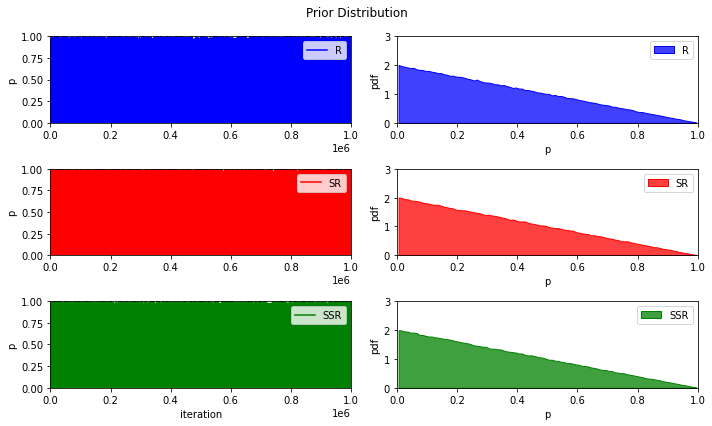

In [5]:
plot_sample(sample, bins=100, xlim=(0, 1), ylim=(0, 3), element='poly')

ガチャの結果$\lbrace x_i \rbrace_{i=1}^n$が観測されているとき、パラメーター$\boldsymbol{p}$の事後分布は

\begin{align}
    P(\boldsymbol{p}|\lbrace x_i \rbrace_{i=1}^n) = \frac{P(\lbrace x_i \rbrace_{i=1}^n|\boldsymbol{p})P(\boldsymbol{p})}{P(\lbrace x_i \rbrace_{i=1}^n)}
\end{align}

### PyroでMCMC解析

In [6]:
def model(x):
    p = pyro.sample('p', dist.Dirichlet(torch.ones(3)))
    with pyro.plate('o', size=n):
        obs = pyro.sample('obs', dist.Categorical(probs=p), obs=torch.tensor(x))

In [7]:
pyro.set_rng_seed(123)

nuts = NUTS(model, jit_compile=True, ignore_jit_warnings=True)
mcmc = MCMC(nuts, 10000, warmup_steps=500)
mcmc.run(x)

Sample: 100%|████████████████████████████| 10500/10500 [01:10, 147.92it/s, step size=8.04e-01, acc. prob=0.907]


In [8]:
mcmc.summary(prob=0.95)


                mean       std    median      2.5%     97.5%     n_eff     r_hat
      p[0]      0.77      0.08      0.78      0.61      0.92   9212.90      1.00
      p[1]      0.19      0.08      0.18      0.05      0.34   8851.88      1.00
      p[2]      0.04      0.04      0.03      0.00      0.11   6961.13      1.00

Number of divergences: 0


In [9]:
post_p = mcmc.get_samples()['p'].numpy()

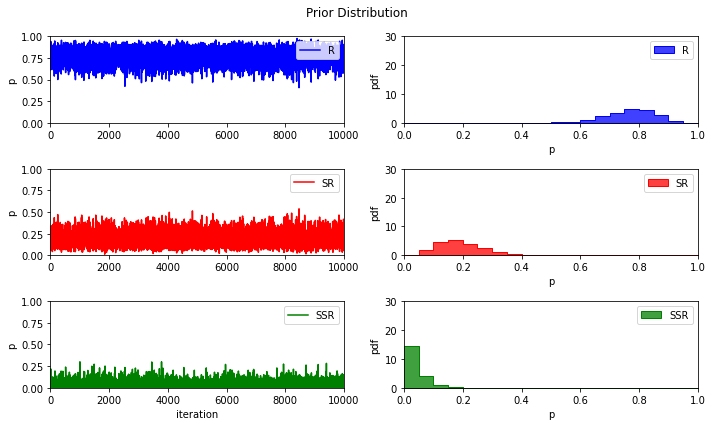

In [10]:
plot_sample(post_p, bins=20, xlim=(0, 1), ylim=(0, 30), element='step')

### Pyroで変分推定

In [11]:
def guide(x):
    a = pyro.param('a', torch.ones(3), constraint=constraints.positive)
    p = pyro.sample('p', dist.Dirichlet(a))

In [12]:
pyro.clear_param_store()
pyro.set_rng_seed(123)

optim = SGD(dict(lr=0.001, momentum=0.9))
elbo = Trace_ELBO()

svi = SVI(model, guide, optim, elbo)

In [13]:
losses = []

with tqdm(range(1000), ncols=90) as pbar:
    for step in pbar:
        loss = svi.step(x)
        losses.append(loss)
        pbar.set_description('Loss {:.4f}'.format(loss))

Loss 14.7705: 100%|██████████████████████████████████| 1000/1000 [00:04<00:00, 232.35it/s]


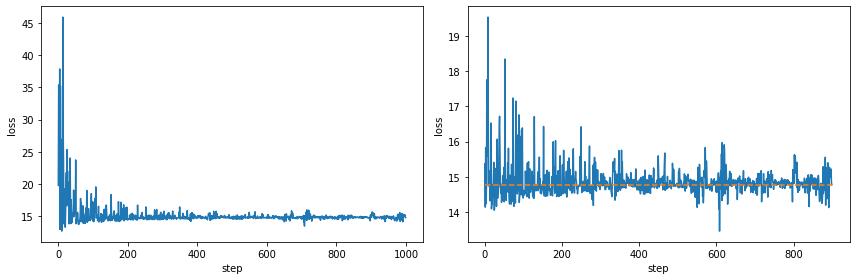

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(losses)
plt.xlabel('step')
plt.ylabel('loss')

plt.subplot(122)
plt.plot(losses[100:])
plt.plot([0, len(losses)-100], [losses[-1], losses[-1]], '--')
plt.xlabel('step')
plt.ylabel('loss')

plt.tight_layout()

plt.show()

In [15]:
a = pyro.get_param_store()['a']
print('Posterior Parameter: [{:.4f}, {:.4f}, {:.4f}]'.format(*[a.data.numpy()[i] for i in range(3)]))

Posterior Parameter: [19.5778, 5.1740, 1.1249]


In [16]:
predictive = Predictive(model=model, guide=guide, num_samples=10000, return_sites=('p',))
with torch.no_grad():
    sample = predictive.get_samples(x=x)
sample = sample['p'].data.numpy().reshape((10000, 3))

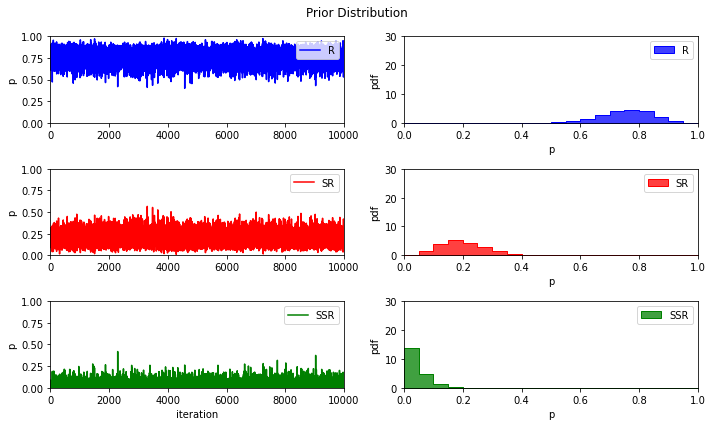

In [17]:
plot_sample(sample, bins=20, xlim=(0, 1), ylim=(0, 30), element='step')

### 解析解

ディリクレ分布はカテゴリ分布の共役事前分布であり、パラメーター$\boldsymbol{p}$の事後分布は解析的に求まる。

事後分布もディリクレ分布となり、そのパラメーター$\hat{\boldsymbol{\alpha}}$は

\begin{equation}
    \hat{\alpha}_j = \alpha_j + \sum_{i=1}^{n}[x_i=j] = \alpha_j + n_j
\end{equation}

つまり、事後分布のパラメーターは、事前分布のパラメーターに、各次元に対応する値が観測された回数を足せばよい。

In [18]:
alpha = np.ones(3) + np.array([count[i] for i in range(3)]) 
sample = stats.dirichlet.rvs(alpha, size=int(1e6), random_state=1)

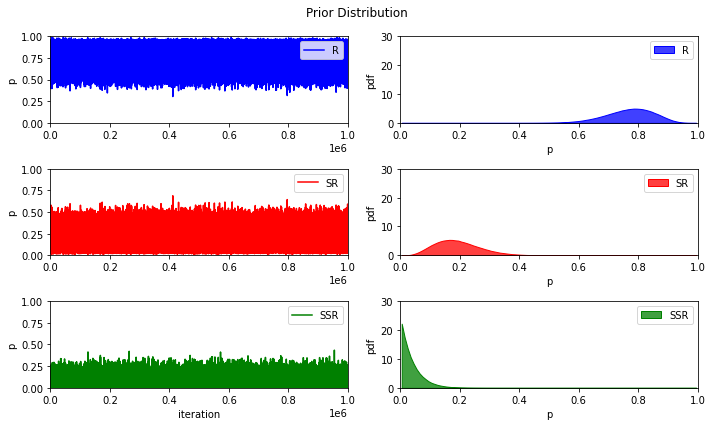

In [19]:
plot_sample(sample, bins=100, xlim=(0, 1), ylim=(0, 30), element='poly')